In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.lbc_unet import SkinnySmallUNetLBP, SmallUNetLBP
from src.models.unet.unet_model import SkinnySmallUNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, SkinnyDSCSmallUNetLBP
from src.models.dsc.dsc_unet import SkinnySmallUNetDSC, SmallUNetDSC

In [2]:
def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)
    
def get_mean_metric(metric_dict, from_epoch, to_epoch=None):
    df = pd.DataFrame.from_dict(metric_dict, orient='index')
    return df[from_epoch:to_epoch].mean().item()

def get_n_params(model, verbose=False):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print('Total Params: ', pytorch_total_params)

    params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params += param.numel()
    if verbose:
        print('Trainable Params: ', params)
    return pytorch_total_params, params

### IoU Metrics

In [3]:
metric_of_interest = 'iou'

# Skinny UNet
skinny_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/noble_forest_358_skinny_small_unet-mean-{metric_of_interest}-epoch.json')

# Small UNet
small_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/laced_disco_238_small_unet_ice-mean-{metric_of_interest}-epoch.json')

# Skinny LBC UNet
skinny_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/trim_field_359_skinny_small_lbc_unet-mean-{metric_of_interest}-epoch.json')

# Small LBC UNet
small_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/sandy_moon_228_small_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Skinny DSC UNet
skinny_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/ancient_grass_357_skinny_small_dsc_unet-mean-{metric_of_interest}-epoch.json')

# Small DSC UNet
small_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/cosmic_waterfall_315_small_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Skinny DSC LBC UNet
skinny_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set_skinny/clear_lake_355_skinny_small_dsc_lbc_unet-mean-{metric_of_interest}-epoch.json')

# Small DSC LBC UNet
small_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/still_paper_311_small_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')


metric_dicts = {
    'skinny_unet': skinny_unet, 
    'small_unet': small_unet,
    'skinny_lbc_unet': skinny_lbc_unet, 
    'small_lbc_unet': small_lbc_unet,
    'skinny_dsc_unet': skinny_dsc_unet,
    'small_dsc_unet': small_dsc_unet,
    'skinny_dsc_lbc_unet': skinny_dsc_lbc_unet,
    'small_dsc_lbc_unet': small_dsc_lbc_unet,
}

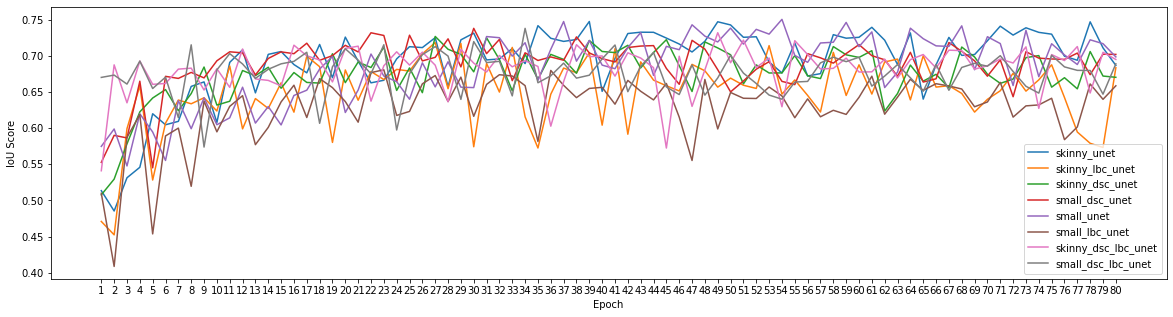

In [4]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(skinny_unet, 'skinny_unet', ax)
plot_json(skinny_lbc_unet, 'skinny_lbc_unet', ax)
plot_json(skinny_dsc_unet, 'skinny_dsc_unet', ax)
plot_json(small_dsc_unet, 'small_dsc_unet', ax)
plot_json(small_unet, 'small_unet', ax)
plot_json(small_lbc_unet, 'small_lbc_unet', ax)
plot_json(skinny_dsc_lbc_unet, 'skinny_dsc_lbc_unet', ax)
plot_json(small_dsc_lbc_unet, 'small_dsc_lbc_unet', ax)
plt.legend();
# ax.set_title('Full Size Comparison');

In [5]:
FROM_EPOCH = 20
avg_metric_dict = {}
for model in metric_dicts.keys():
    avg_metric_dict[model] = get_mean_metric(metric_dicts[model], FROM_EPOCH)

In [6]:
avg_metric_dict

{'skinny_unet': 0.7107929944992065,
 'small_unet': 0.7044796794652939,
 'skinny_lbc_unet': 0.6595937867959341,
 'small_lbc_unet': 0.6416343748569489,
 'skinny_dsc_unet': 0.6863188832998276,
 'small_dsc_unet': 0.6951989223559697,
 'skinny_dsc_lbc_unet': 0.6852938671906789,
 'small_dsc_lbc_unet': 0.677533096075058}

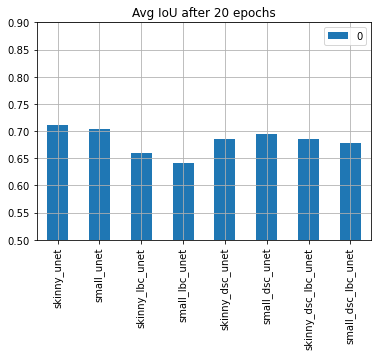

In [7]:
ax = pd.DataFrame.from_dict(avg_metric_dict, orient='index').plot.bar(ylim=(0.5, 0.90), title='Avg IoU after 20 epochs')
ax.grid();

In [8]:
pd.DataFrame.from_dict(avg_metric_dict, orient='index')

,0
skinny_unet,0.710793
small_unet,0.704480
skinny_lbc_unet,0.659594
small_lbc_unet,0.641634
skinny_dsc_unet,0.686319
small_dsc_unet,0.695199
skinny_dsc_lbc_unet,0.685294
small_dsc_lbc_unet,0.677533


### Model Parameters

In [2]:
skinny_unet_model = SkinnySmallUNet(n_channels=3, n_classes=3, bilinear=True)
small_unet_model = SmallUNet(n_channels=3, n_classes=3, bilinear=True)
skinny_lbc_unet_model = SkinnySmallUNetLBP(3, 3)
small_lbc_unet_model = SmallUNetLBP(3, 3)
skinny_dsc_unet_model = SkinnySmallUNetDSC(n_channels=3, n_classes=3, bilinear=True)
small_dsc_unet_model = SmallUNetDSC(n_channels=3, n_classes=3, bilinear=True)
skinny_dsc_lbc_unet_model = SkinnyDSCSmallUNetLBP(3, 3)
small_dsc_lbc_unet_model = DSCSmallUNetLBP(3, 3)

models_dict = {
    'skinny_unet': skinny_unet_model,
    'small_unet': small_unet_model,
    'skinny_lbc_unet': skinny_lbc_unet_model,
    'small_lbc_unet': small_lbc_unet_model,
    'skinny_dsc_unet': skinny_dsc_unet_model,
    'small_dsc_unet': small_dsc_unet_model,
    'skinny_dsc_lbc_unet': skinny_dsc_lbc_unet_model,
    'small_dsc_lbc_unet': small_dsc_lbc_unet_model,
}

In [16]:
model_tot_param_dict, model_train_param_dict = {}, {}
for model in models_dict.keys():
#     print(model, ': ')
    tot, train = get_n_params(models_dict[model])
    model_tot_param_dict[model] = tot
    model_train_param_dict[model] = train

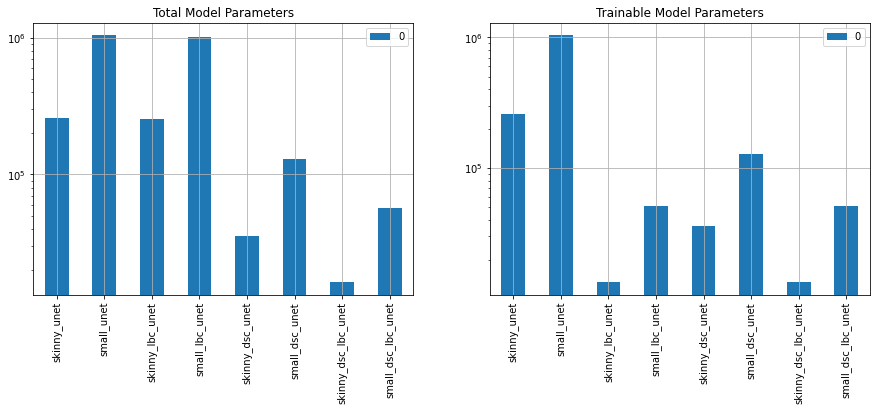

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(model_tot_param_dict, orient='index').plot.bar(ax=axs[0], title='Total Model Parameters', logy=True)
pd.DataFrame.from_dict(model_train_param_dict, orient='index').plot.bar(ax=axs[1], title='Trainable Model Parameters', logy=True)
axs[0].grid()
axs[1].grid();

In [18]:
pd.DataFrame.from_dict(model_tot_param_dict, orient='index')

,0
skinny_unet,260451
small_unet,1036995
skinny_lbc_unet,253050
small_lbc_unet,1009818
skinny_dsc_unet,35777
small_dsc_unet,128865
skinny_dsc_lbc_unet,16260
small_dsc_lbc_unet,57060


In [19]:
pd.DataFrame.from_dict(model_train_param_dict, orient='index')

,0
skinny_unet,260451
small_unet,1036995
skinny_lbc_unet,13353
small_lbc_unet,51273
skinny_dsc_unet,35777
small_dsc_unet,128865
skinny_dsc_lbc_unet,13353
small_dsc_lbc_unet,51273


### FLOPs

In [20]:
device = 'cpu'
inp = torch.rand(2,3,224,224).to(device)

model_flop_dict = {}
for model in models_dict.keys():
    flops = FlopCountAnalysis(models_dict[model].to(device), inp)
    model_flop_dict[model] = flops.total()/1000000

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Uns

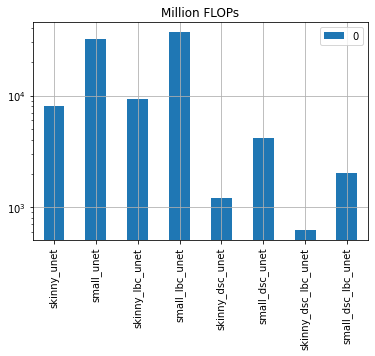

In [21]:
ax = pd.DataFrame.from_dict(model_flop_dict, orient='index').plot.bar(title='Million FLOPs', logy=True)
ax.grid();

In [22]:
pd.DataFrame.from_dict(model_flop_dict, orient='index')

,0
skinny_unet,8073.117696
small_unet,31868.583936
skinny_lbc_unet,9289.785344
small_lbc_unet,36912.676864
skinny_dsc_unet,1198.905344
small_dsc_unet,4142.028800
skinny_dsc_lbc_unet,624.791552
small_dsc_lbc_unet,2016.071680


### Run Time

In [ ]:
cuda_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cuda_v3.json')
cpu_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cpu_v3.json')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(cuda_dict, orient='index').plot.bar(ax=axs[0], title='Train 3 Epochs on GPU')
pd.DataFrame.from_dict(cpu_dict, orient='index').plot.bar(ax=axs[1], title='Train 3 Epochs on CPU')
axs[0].grid()
axs[1].grid();

In [4]:
def net_time_test(net, times, input_, mobile=False):
    backprop_duration = 0
    inference_duration = 0
    for i in range(times):
        if mobile:
            inference_start = time()
            out = net(input_)['out']
            inference_end = time()
        else:
            inference_start = time()
            out = net(input_)
            inference_end = time()
        backprop_start = time()
        out.backward(gradient=torch.randn(2, 3, 256, 256).to(device=device))
        backprop_end = time()
        backprop_duration += backprop_end - backprop_start
        inference_duration += inference_end - inference_start
    return backprop_duration, inference_duration

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


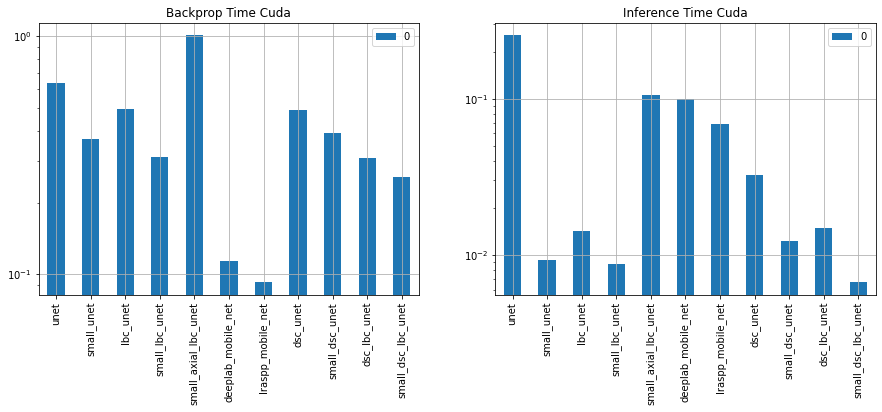

In [5]:
device = 'cuda'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=False)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time Cuda', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time Cuda', logy=True)
axs[0].grid()
axs[1].grid();

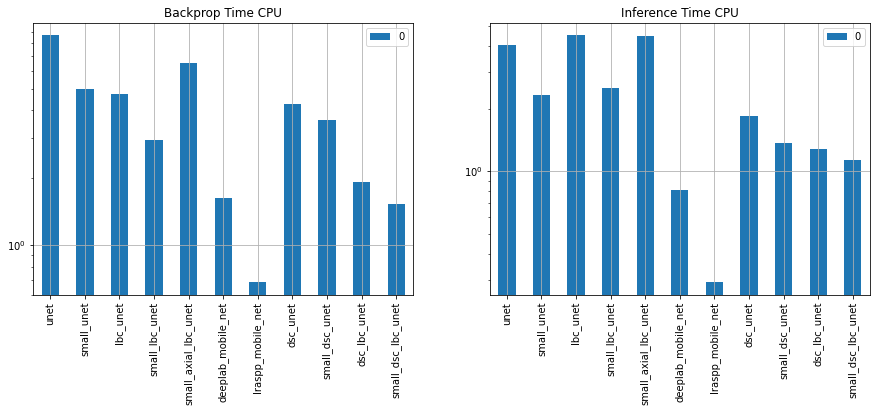

In [6]:
device = 'cpu'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time CPU', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time CPU', logy=True)
axs[0].grid()
axs[1].grid();

In [3]:
from torchvision import models
from torchsummary import summary
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large

In [9]:
summary(skinny_lbc_unet_model.to('cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
           ConvLBP-2          [-1, 3, 256, 256]              81
            Conv2d-3         [-1, 32, 256, 256]             128
      BlockLBPUNet-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
       BatchNorm2d-6         [-1, 32, 128, 128]              64
           ConvLBP-7         [-1, 32, 128, 128]           9,216
            Conv2d-8         [-1, 64, 128, 128]           2,112
      BlockLBPUNet-9         [-1, 64, 128, 128]               0
          DownLBP-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
      BatchNorm2d-12           [-1, 64, 64, 64]             128
          ConvLBP-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [2]:
summary(UNet(n_channels=3, n_classes=3, bilinear=True).to('cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
deeplab_mobile_net_model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 